# LMUNet: Landscape metrics unet

**ORIGINAL SOURCE:** [Top 100 solution - SIIM-ACR Pneumothorax Segmentation](https://amaarora.github.io/2020/09/06/siimacr.html#train-and-valid-augmentations)

The Data-structure should look like this (old names: 

```
├── data
│   ├── dataset512
│   ├── dicom-images-test
│   └── dicom-images-train
└── src
    └── pneumothorax-segmentation 
```


## Preparations

### a)  Imports

remove obsolete ones

In [1]:
import os
import torch
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
#import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader
import torch.nn as nn
#from torch.nn import MSELoss
from collections import defaultdict
import torchvision
import albumentations as albu
from albumentations.pytorch.transforms import ToTensorV2
import torch.nn.functional as F
from sklearn.model_selection import StratifiedKFold
#from torch.utils.data.sampler import Sampler
import sys; sys.path.append('../pneumothorax-segmentation/unet_pipeline/')
#from Losses import ComboLoss, dice_metric
#os.cpu_count()

In [2]:
#import tqdm
try:
    get_ipython().__class_._name__
    from tqdm.notebook import tqdm
except:
    from tqdm import tqdm

### b) Config (Hyperparameters)

The [ComboLoss](https://github.com/sneddy/pneumothorax-segmentation/blob/master/unet_pipeline/Losses.py#L104) function used in CRITERION below also comes from the winning solution by Anuar. 

```
Adjust:
    - file paths
    - batch size
    - learning rate
    - epochs
    - criterion (=loss function)
    - train or evaluate
    - etc
```

In [54]:
IMG_SIZE         = 128
#DATA_DIR         = Path(f'../data/dataset{IMG_SIZE}/')
DATA_DIR         = Path(f'../notebooks/data')
#DATA_DIR         = Path(f'/data')
TRAIN_IMG_DIR    = DATA_DIR/'100k_landscapes_no_classes'
#TRAIN_LBL_DIR    = DATA_DIR/'npy_10000_random_moving_window_sidi'
TRAIN_LBL_DIR    = DATA_DIR/'npy_3_class_lsm_l_sidi_5_mov_win'
#RLE_DF           = pd.read_csv('../data/train-rle.csv', names=['ImageId', 'EncodedPixels'], skiprows=1)
#RLE_DF           = pd.read_csv('data/metric_list_reti_futu.csv', names=['ImageId', 'EncodedPixels'], skiprows=1)
RLE_DF           = pd.read_csv('data/100k_ls_metr.csv',  names=['ImageId', 'EncodedPixels'], skiprows=1)
#RLE_DF           = pd.read_csv('data/100k_ls_metr.csv', header=None)
#RLE_DF           = pd.read_csv('data/metric_list_reti_futu.csv', header=None)
KFOLD_PATH       = DATA_DIR/'RLE_kfold.csv'
TRAIN_BATCH_SIZE = 8 #[8, 14, 16, 32]
VALID_BATCH_SIZE = 8
TEST_BATCH_SIZE = 16
USE_SAMPLER      = False
#POSTIVE_PERC     = 0.8
#ENCODER          = 'se_resnext50_32x4d'
#ENCODER_WEIGHTS  = 'imagenet'
#CLASSES          = ['mask']
#METRIC_NAMES     = ['lsm_l_sidi','lsm_l_joinent']
#NUM_METRICS      = len(['lsm_l_sidi','lsm_l_joinent'])
#ACTIVATION       = None 
DEVICE           = 'cuda'
#PRETRAINED_PATH  = '../data/bst_model512_fold2_0.9565.bin'
#PRETRAINED_PATH  = 'data/saved_models/first_working_evaluation_score/bst_model128_fold4_9.999999747378752e-05.bin'
PRETRAINED_PATH  = 'outputs/saved_models/bst_model128_fold8_0.6747999787330627.bin'
#PRETRAINED       = True
LEARNING_RATE    = 2e-5
#LEARNING_RATE    = 0.1
#LEARNING_RATE    = 0.01
#EPOCHS           = 50
EPOCHS           = 100
#LOSS_FN          = 'mixed'
#LOSS_FN          = 'MSE'
#LOSS_FN          = 'RMSE'
LOSS_FN          = 'MAE'
#LOSS_FN          = 'R2'
#LOSS_FN           = 'pixels'
#EVAL_FN         = 'MSE'
EVAL_FN         = 'R2'
#CRITERION        = ComboLoss(**{'weights':{'bce':3, 'dice':1, 'focal':4}})
USE_CRIT         = True
TRAIN_MODEL      = False
TEST_MODEL       = True
#EVALUATE         = False
KFOLD_SPLITS     = 10
#FOLD_IDS          = range(KFOLD_SPLITS-1)
FOLD_ID          = 8
TEST_ID           = 9
#NUM_WORKERS      = 4
NUM_WORKERS      = 12
GRID_SEARCH      = False
GRID_SEARCH_OPTIM      = False

### c) Visualization functions

In [4]:
def matplotlib_imshow(img, one_channel=False):
    fig,ax = plt.subplots(figsize=(8,8))
    ax.imshow(img.permute(1,2,0).numpy())

In [5]:
def visualize(landscape, metric, left_title = "Landscape", right_title = "Metric"):
    """PLot images in one row."""
    #landscapes = {k:v.numpy() for k,v in landscapes.items() if isinstance(v, torch.Tensor)} #convert tensor to numpy 
    #landscape = landscape.numpy()
    #metric = metric.numpy()
    #n = len(landscapes)
    columns = 2
    rows = 1
    fig = plt.figure(figsize=(8, 8))
    fig.add_subplot(rows, columns, 1)
    plt.title(left_title)
    #plt.title("Landscape")
    #landscape, metric = landscapes['landscape'], landscapes['metric']
    #plt.imshow(landscape.transpose(1,2,0), vmin=0, vmax=1)
    plt.imshow(landscape)
    fig.add_subplot(rows, columns, 2)
    plt.title(right_title)
    #plt.title("Metric")
    plt.imshow(metric)
    #if metric.max()>0:
    #    plt.imshow(metric.squeeze(0), alpha=0.25)
    plt.show()

## Dataset

### d) Create k-fold splits - empty right now

In [6]:
'''
# create k folds train file if it doesn't exist already
if not os.path.exists(KFOLD_PATH):
    RLE_DF['has_mask'] = 0
    RLE_DF.loc[RLE_DF.EncodedPixels!='-1', 'has_mask'] = 1
    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)
    RLE_DF['kfold']=-1
    for fold, (train_index, test_index) in enumerate(kf.split(X=RLE_DF.ImageId, y=RLE_DF.has_mask)):
            RLE_DF.loc[test_index, 'kfold'] = fold
    RLE_DF.to_csv(KFOLD_PATH, index=False)
'''

"\n# create k folds train file if it doesn't exist already\nif not os.path.exists(KFOLD_PATH):\n    RLE_DF['has_mask'] = 0\n    RLE_DF.loc[RLE_DF.EncodedPixels!='-1', 'has_mask'] = 1\n    kf = StratifiedKFold(n_splits=KFOLD_SPLITS)\n    RLE_DF['kfold']=-1\n    for fold, (train_index, test_index) in enumerate(kf.split(X=RLE_DF.ImageId, y=RLE_DF.has_mask)):\n            RLE_DF.loc[test_index, 'kfold'] = fold\n    RLE_DF.to_csv(KFOLD_PATH, index=False)\n"

In [7]:
'''
#for FOLD_ID in FOLD_IDS:
DF       = pd.read_csv(KFOLD_PATH)
TRAIN_DF = DF.query(f'kfold!={FOLD_ID} and kfold!={TEST_ID}').reset_index(drop=True)
VAL_DF   = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)
TEST_DF  = DF.query(f'kfold=={TEST_ID}').reset_index(drop=True)
#print(len(TRAIN_DF), len(VAL_DF), len(TEST_DF))
#print(TRAIN_DF.ImageId[0], VAL_DF.ImageId[0], TEST_DF.ImageId[0])
'''

"\n#for FOLD_ID in FOLD_IDS:\nDF       = pd.read_csv(KFOLD_PATH)\nTRAIN_DF = DF.query(f'kfold!={FOLD_ID} and kfold!={TEST_ID}').reset_index(drop=True)\nVAL_DF   = DF.query(f'kfold=={FOLD_ID}').reset_index(drop=True)\nTEST_DF  = DF.query(f'kfold=={TEST_ID}').reset_index(drop=True)\n#print(len(TRAIN_DF), len(VAL_DF), len(TEST_DF))\n#print(TRAIN_DF.ImageId[0], VAL_DF.ImageId[0], TEST_DF.ImageId[0])\n"

### e) Data augmentation ("transforms") - not working right now

In [8]:
'''
# Train transforms
TFMS = albu.Compose([
    ToTensorV2(),
    #albu.HorizontalFlip(always_app), # doesn't really matter?
    #albu.Rotate(limit=10),  # rotate could be fine, but needs to be the same
    #albu.Normalize(mean=[0.5], std=[0.5], max_pixel_value=1), # normalize also fine
    #ToTensorV2()
    ],
    #additional_targets={'metric': 'metric'}
)

# Test transforms
VAL_TFMS = albu.Compose([
    #albu.Normalize(),
    ToTensorV2(),
])
'''

"\n# Train transforms\nTFMS = albu.Compose([\n    ToTensorV2(),\n    #albu.HorizontalFlip(always_app), # doesn't really matter?\n    #albu.Rotate(limit=10),  # rotate could be fine, but needs to be the same\n    #albu.Normalize(mean=[0.5], std=[0.5], max_pixel_value=1), # normalize also fine\n    #ToTensorV2()\n    ],\n    #additional_targets={'metric': 'metric'}\n)\n\n# Test transforms\nVAL_TFMS = albu.Compose([\n    #albu.Normalize(),\n    ToTensorV2(),\n])\n"

In [9]:
'''
# chat gpt's suggestions:

import torch
import torchvision.transforms as transforms

# Define the transforms to be applied to the input images
# problem: not applied evenly on landscapes and metrics...
TFMS = transforms.Compose([
    transforms.ToTensor(),
    #transforms.RandomHorizontalFlip(),  # flips kind of pointless?
    #transforms.RandomVerticalFlip(),
    #transforms.functional.vflip(),    
    #transforms.RandomRotation(30),
    #transforms.functional.rotate(angle=30), # angle seems nice
    #transforms.RandomCrop(size=128),  # crop? yeah seems good.
    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), #pointless
    #transforms.GaussianBlur(kernel_size=3), #pointless
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

VAL_TFMS = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5])
])

TEST_TFMS = transforms.Compose([
    transforms.ToTensor()#,
    #transforms.Normalize(mean=[0.5], std=[0.5])
])


'''

"\n# chat gpt's suggestions:\n\nimport torch\nimport torchvision.transforms as transforms\n\n# Define the transforms to be applied to the input images\n# problem: not applied evenly on landscapes and metrics...\nTFMS = transforms.Compose([\n    transforms.ToTensor(),\n    #transforms.RandomHorizontalFlip(),  # flips kind of pointless?\n    #transforms.RandomVerticalFlip(),\n    #transforms.functional.vflip(),    \n    #transforms.RandomRotation(30),\n    #transforms.functional.rotate(angle=30), # angle seems nice\n    #transforms.RandomCrop(size=128),  # crop? yeah seems good.\n    #transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), #pointless\n    #transforms.GaussianBlur(kernel_size=3), #pointless\n    #transforms.Normalize(mean=[0.5], std=[0.5])\n])\n\nVAL_TFMS = transforms.Compose([\n    transforms.ToTensor(),\n    #transforms.Normalize(mean=[0.5], std=[0.5])\n])\n\nTEST_TFMS = transforms.Compose([\n    transforms.ToTensor()#,\n    #transforms.Normalize(

### f) Dataset

In [10]:
# move to imports
#from Dataset_test import LandscapeMetricsDataset
#from Dataset_test_kfold import LandscapeMetricsDataset

In [11]:

#train_dataset = LandscapeMetricsDataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR)#, TFMS)# , TFMS)#, augmentation=transforms_train) 
#val_dataset   = LandscapeMetricsDataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR)#, VAL_TFMS)#, VAL_TFMS) 


In [12]:
# if loading multiple datasets from multiple folders with the same indices:
#train_dataset_01 = LandscapeMetricsDataset(TRAIN_DF, TRAIN_IMG_DIR_01, TRAIN_LBL_DIR_01)#, TFMS)# , TFMS)#, augmentation=transforms_train) 
#train_dataset_02 = LandscapeMetricsDataset(TRAIN_DF, TRAIN_IMG_DIR_02, TRAIN_LBL_DIR_02)#, TFMS)# , TFMS)#, augmentation=transforms_train) 
#train_dataset = torch.utils.data.ConcatDataset(train_dataset_01, train_dataset_02)

In [13]:
'''
train_dataset = LandscapeMetricsDataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TFMS) 
val_dataset   = LandscapeMetricsDataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TEST_TFMS) 

#landscapes_dataset = LandscapeMetricsDataset(ls_list=TRAIN_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR)
#landscapes_dataset = LandscapeMetricsDataset(ls_list=TRAIN_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR)
#landscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR, augmentation=transforms_train)
#landscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR, augmentation=TFMS)
'''

'\ntrain_dataset = LandscapeMetricsDataset(TRAIN_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TFMS) \nval_dataset   = LandscapeMetricsDataset(VAL_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR, TEST_TFMS) \n\n#landscapes_dataset = LandscapeMetricsDataset(ls_list=TRAIN_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR)\n#landscapes_dataset = LandscapeMetricsDataset(ls_list=TRAIN_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR)\n#landscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR, augmentation=transforms_train)\n#landscapes_dataset = LandscapeMetricsDataset(ls_list=RLE_DF, landscape_dir=TRAIN_IMG_DIR, metrics_dir=TRAIN_LBL_DIR, augmentation=TFMS)\n'

In [14]:
#len(train_dataset)

In [15]:
# https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split
# split dataset into training and testing. 
# rando generator seed for reproducabitly included!
#from torch.utils.data import DataLoader, random_split

# split dataset (size: 95954)
#train_dataset, val_dataset, test_dataset = random_split(dataset=landscapes_dataset, lengths=[1000,84000,10955], generator=torch.Generator().manual_seed(42))
#train_dataset, val_dataset, test_dataset = random_split(dataset=landscapes_dataset, lengths=[75000,10000,10954], generator=torch.Generator().manual_seed(42))
#train_dataset, val_dataset, test_dataset = random_split(dataset=landscapes_dataset, lengths=[750,125,125], generator=torch.Generator().manual_seed(42))


In [16]:
# sanity check
#landscape, metric = train_dataset[136]['landscape'], train_dataset[136]['metric']
#landscape = train_dataset[1]['landscape']

#landscape.shape, metric.shape
# (torch.Size([1, 128, 128]), torch.Size([1, 128, 128]))

In [17]:
# plot one with mask 
#visualize(train_dataset[0]['landscape'].squeeze(), train_dataset[0]['metric'].squeeze())


### g) Sampler

Do I want/need sampler? Using randomsampler, which is applied by setting shuffle=True in DataLoader

### h) DataLoaders

In [18]:
'''
# dataloaders
# shuffle = True means random sampler, which is fine.
train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, 
                              shuffle=True if not USE_SAMPLER else False, 
                              num_workers=NUM_WORKERS, 
                              sampler=SAMPLER if USE_SAMPLER else None)
val_dataloader   = DataLoader(val_dataset, VALID_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
'''

'\n# dataloaders\n# shuffle = True means random sampler, which is fine.\ntrain_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, \n                              shuffle=True if not USE_SAMPLER else False, \n                              num_workers=NUM_WORKERS, \n                              sampler=SAMPLER if USE_SAMPLER else None)\nval_dataloader   = DataLoader(val_dataset, VALID_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)\n'

In [19]:
'''
# sanity check
landscapes, metrics = next(iter(train_dataloader))['landscape'], next(iter(train_dataloader))['metric']
landscapes.shape, metrics.shape
# should look like this: (torch.Size([14, 3, 512, 512]), torch.Size([14, 1, 512, 512]))
'''

"\n# sanity check\nlandscapes, metrics = next(iter(train_dataloader))['landscape'], next(iter(train_dataloader))['metric']\nlandscapes.shape, metrics.shape\n# should look like this: (torch.Size([14, 3, 512, 512]), torch.Size([14, 1, 512, 512]))\n"

In [20]:
# plot train images
#ls_grid = torchvision.utils.make_grid(landscapes[:9], nrow=3, normalize=True)
#matplotlib_imshow(ls_grid)

In [21]:
#metr_grid = torchvision.utils.make_grid(metrics[:9], nrow=3, normalize=True)
#matplotlib_imshow(metr_grid)

## Loading Multi-metric dataset

In [22]:
from Dataset_test_many_metrics import LandscapeMetricsDataset
import pandas as pd
from pathlib import Path
from torch.utils.data import DataLoader, random_split
import torch

In [23]:
TRAIN_DF = pd.read_csv('data/metric_list_5_class_sidi_10k.csv', header=None)
DATA_DIR         = Path(f'../notebooks/data')
#TRAIN_LS_DIR = DATA_DIR/'100k_landscapes_no_classes'
TRAIN_LS_DIR = DATA_DIR/'10k_sidi_5_class_ls'
TRAIN_METR_DIR = DATA_DIR/'metric_stacks_experiment'
TRAIN_BATCH_SIZE = 8
NUM_WORKERS = 12
NUM_METRICS = 3

In [24]:
metrics_dataset = LandscapeMetricsDataset(TRAIN_DF, TRAIN_LS_DIR, TRAIN_METR_DIR, metr_norm=True)#, TFMS)# , TFMS)#, augmentation=transforms_train) 

In [25]:
train_dataset, val_dataset, test_dataset = random_split(dataset=metrics_dataset, lengths=[8000, 1500, 500], generator=torch.Generator().manual_seed(42))

In [26]:
train_dataset[1]['metric'][1].unsqueeze(0).shape

torch.Size([1, 128, 128])

In [27]:
train_dataloader = DataLoader(train_dataset, TRAIN_BATCH_SIZE, 
                              shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_dataset, TRAIN_BATCH_SIZE, 
                              shuffle=False, num_workers=NUM_WORKERS)

In [28]:
# sanity check
landscapes, metrics = next(iter(train_dataloader))['landscape'], next(iter(train_dataloader))['metric']
landscapes.shape, metrics.shape
# should look like this: (torch.Size([14, 3, 512, 512]), torch.Size([14, 1, 512, 512]))

(torch.Size([8, 1, 128, 128]), torch.Size([8, 3, 128, 128]))

## Model and Training

### i) Loss

In [29]:
# pixel wise mse loss
if LOSS_FN == 'pixels':
    def pixel_wise_mse_loss(input, target):
        return torch.mean((input - target)**2)
    criterion = pixel_wise_mse_loss

In [30]:
#losses
#LOSS_FN          = 'RMSE'

if LOSS_FN == 'MAE':
    criterion = nn.L1Loss()

# MSE
elif LOSS_FN == 'MSE' or LOSS_FN == 'RMSE':
    criterion = nn.MSELoss()

### j) Model

From [PyTorch Segmentation Models](https://github.com/qubvel/segmentation_models.pytorch):

In [31]:
#original
'''
import segmentation_models_pytorch as smp
#import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=3,     
    #classes=len(CLASSES), 
    activation=ACTIVATION,
)
'''

'\nimport segmentation_models_pytorch as smp\n#import segmentation_models_pytorch as smp\n\nmodel = smp.Unet(\n    encoder_name=ENCODER, \n    encoder_weights=ENCODER_WEIGHTS, \n    classes=3,     \n    #classes=len(CLASSES), \n    activation=ACTIVATION,\n)\n'

In [32]:
# importen just_unet
from unet_num_metr import unet, Decoder

block_test torch.Size([1, 64, 128, 128])
encoder_test torch.Size([1, 64, 128, 128])
encoder_test torch.Size([1, 128, 64, 64])
encoder_test torch.Size([1, 256, 32, 32])
encoder_test torch.Size([1, 512, 16, 16])
decoder_test torch.Size([1, 64, 64, 64])
unet_output_dim_test torch.Size([1, 1, 128, 128])


In [33]:
#model = unet
#ENC_CHS = (1,64,128,256,512,1024)
#DEC_CHS= (1024,512,256,128,64)
ENC_CHS = (1,64,128,256,512)
DEC_CHS= (512,256,128,64)
#model = unet(enc_chs=ENC_CHS, dec_chs=DEC_CHS, num_metr=2)
model = unet(enc_chs=ENC_CHS, dec_chs=DEC_CHS, num_metr=NUM_METRICS)
#model = unet(retain_dim=False)

### k) Early Stopping

epoch_score = accuracy at that epoch
model_path = where to save the model
patience = after how many steps of no progress to stop training

Saves one model when beginning, i.e. when no best score is yet available.
Why np.copy ? Maybe to turn epoch_score it into np object?

IF the accuracy (+delta) decreased: patience counter incremented by one, stopping once patience is reached.
Otherwise: continue trianing, reset counter, update best score with new score.

Save checkpoint: sved best score is intermittently saved as val_score, new best_score is compared to old val_score and printed out, state_dict is saved at model path.

In [34]:
class EarlyStopping:
    def __init__(self, patience=7, mode="max", delta=0.0001): # how big delta?
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.best_score = None
        self.early_stop = False
        self.delta = delta
        if self.mode == "min":
            self.val_score = np.Inf
        else:
            self.val_score = -np.Inf

    def __call__(self, epoch_score, model, model_path):
        if self.mode == "min":
            score = -1.0 * epoch_score
        else:
            score = np.copy(epoch_score)

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)

        elif ((EVAL_FN == 'MSE' and score > self.best_score - self.delta) or 
              (EVAL_FN == 'R2' and score < self.best_score + self.delta)):

            self.counter += 1
            print(
                "EarlyStopping counter: {} out of {}".format(
                    self.counter, self.patience
                )
            )
            if self.counter >= self.patience:
                self.early_stop = True
                #self.counter = 0
            
        else:
            self.best_score = score
            self.save_checkpoint(epoch_score, model, model_path)
            self.counter = 0

    def save_checkpoint(self, epoch_score, model, model_path):
        model_path = Path(model_path)
        parent = model_path.parent
        os.makedirs(parent, exist_ok=True)
        if epoch_score not in [-np.inf, np.inf, -np.nan, np.nan]:
            print(
                "Validation score improved ({} --> {}). Model saved at at {}!".format(
                    self.val_score, epoch_score, model_path
                )
            )
            torch.save(model.state_dict(), model_path)
        self.val_score = epoch_score

### l) Averagemeter

Averagemeter plays a role in taking care of the losses.

It's initialized in train_one_epoch, having the values set at zero.
Reset appears to be unused.
It gets updated with the current loss, which is handed as "val", and batch_size as n.
val is therefore the loss score.
sum is previous sum loss score plus val multiplied by batch size.
count is previous batches + new one
avg is sum of all loss scores divided by count of all batches.

Train one epoch is doing what it says it does.

In [35]:
class AverageMeter:
    def __init__(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

### m) Train one epoch

In [36]:
def train_one_epoch(train_loader, model, optimizer, loss_fn, accumulation_steps=1, device='cuda'):
    losses = AverageMeter()
    model = model.to(device)
    model.train()
    if accumulation_steps > 1: 
        optimizer.zero_grad()
    tk0 = tqdm(train_loader, total=len(train_loader))
    for b_idx, data in enumerate(tk0):
        for key, value in data.items():
            data[key] = value.to(device)
            #print(data['landscape'].size())
        if accumulation_steps == 1 and b_idx == 0:
            optimizer.zero_grad()
        out  = model(data['landscape'])
        #print(out.size())
        loss = loss_fn(out, data['metric'])
        if LOSS_FN == 'RMSE':
            loss = torch.sqrt(loss)
        with torch.set_grad_enabled(True):
            loss.backward()
            if (b_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
        losses.update(loss.item(), train_loader.batch_size)
        tk0.set_postfix(loss=losses.avg, learning_rate=optimizer.param_groups[0]['lr'])
    return losses.avg

In [37]:
#print(train_one_epoch(train_loader=train_dataloader, model=model, optimizer=optimizer, loss_fn=criterion, accumulation_steps=1, device='cuda'))


### n) Evaluation Metric

In [38]:

# from ChatGPT adjusted:
# "When using Mean Squared Error (MSE) loss for image regression in PyTorch,
# you can compute the validation accuracy function using the following code:"
# useing torcheval.metrics.MeanSquaredError()
# torcheval.metrics.R2Score

#https://pytorch.org/torcheval/main/torcheval.metrics.html#regression-metrics
from torcheval.metrics import MeanSquaredError, R2Score

if EVAL_FN == 'MSE':
    eval_metric = MeanSquaredError()
    
elif EVAL_FN == 'R2':
    eval_metric = R2Score()

def evaluate(val_loader, model, device='cuda', criterion=eval_metric):
    """
    Computes the validation accuracy of the model on the validation set.
    """
    #losses = AverageMeter()
    #val_loss = 0.0
    
    model = model.to(device)
    model.eval() # set the model to evaluation mode
    tk0 = tqdm(val_loader, total=len(val_loader))

    with torch.no_grad():
        for b_idx, data in enumerate(tk0):
            for key, value in data.items():
                data[key] = value.to(device)
                #print(data['landscape'].size())
            out   = model(data['landscape'])  
                     
            # chatgpt suggest flaten:
            targets = data['metric']
            #inputs_flat = inputs.view(inputs.shape[0], -1)
            targets_flat = targets.view(targets.shape[0], -1).cpu()
            outputs_flat = out.view(out.shape[0], -1).cpu()
            # calculate the loss
            #loss = criterion(out, data['metric']).cpu()
            #criterion.update(out, data['metric']).cpu()
            criterion.update(outputs_flat, targets_flat)#.cpu()            
            val_loss = criterion.compute()

            #val_loss += loss.item() * landscapes.size(0) # accumulate the validation loss
            #losses.update(loss.mean().item(), val_loader.batch_size)
            #losses.update(loss.item(), val_loader.batch_size)
           
        # calculate the average validation loss
            #val_loss = val_loss / len(val_loader.dataset)
            
            tk0.set_postfix(val_score=val_loss)
            
        criterion.reset()
    
    # calculate the validation accuracy (in this case, MSE)
    #val_accuracy = val_loss
    #return losses.avg
    return val_loss
    #return val_accuracy


In [39]:
# testing evaluation function on pretrained model

#best_model_path = PRETRAINED_PATH
#model.load_state_dict(torch.load(best_model_path))
#model = model.to('cuda')
#print(evaluate(val_loader=val_dataloader, model=model, device='cuda', criterion=eval_metric))


In [40]:
'''
if PRETRAINED: 
    model.load_state_dict(torch.load(PRETRAINED_PATH))
'''

'\nif PRETRAINED: \n    model.load_state_dict(torch.load(PRETRAINED_PATH))\n'

In [41]:
optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)

### o) Train model

In [42]:
#es = EarlyStopping(patience=3, mode='max')
es = EarlyStopping(patience=10, mode='max')

In [43]:
criterion

L1Loss()

In [44]:
if TRAIN_MODEL:
    for epoch in range(EPOCHS):
        loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
        #dice = evaluate(val_dataloader, model, metric=acc_metric)
        #dice = evaluate(val_dataloader, model, metric=metric)
        #dice = evaluate(val_dataloader, model, criterion=criterion)        
        #dice = evaluate(val_dataloader, model, criterion=eval_metric)   
        eval_score = evaluate(val_dataloader, model, criterion=eval_metric)      
        scheduler.step()
        print(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL SCORE: {eval_score}")
        es(eval_score, model, model_path=f"../notebooks/outputs/saved_models/bst_model{IMG_SIZE}_fold{FOLD_ID}_{np.round(eval_score,4)}.bin")
        #best_model = f"../data/bst_model{IMG_SIZE}__fold{FOLD_ID}_{np.round(es.best_score,4)}.bin"
        #es(dice, model, model_path=f"../notebooks/data/bst_model{IMG_SIZE}_fold{FOLD_ID}_{str(np.round(dice,4))[2:]}.bin")
        #best_model = f"../notebooks/data/saved_models/bst_model{IMG_SIZE}__fold{FOLD_ID}_{np.round(es.best_score,4)}.bin"
        if es.early_stop:
            print('\n\n -------------- EARLY STOPPING -------------- \n\n')
            break
            
'''         ## whats this for?  
if EVALUATE: 
    #valid_score = evaluate(val_dataloader, model, metric=metric)
    valid_score = evaluate(val_dataloader, model, metric=acc_metric)
    print(f"Valid dice score: {valid_score}")
'''

100%|██████████| 188/188 [00:14<00:00, 12.86it/s, val_score=tensor(-0.5917)]


EPOCH: 0, TRAIN LOSS: 0.33475837123394014, VAL SCORE: -0.5917108058929443
Validation score improved (-inf --> -0.5917108058929443). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_-0.59170001745224.bin!


100%|██████████| 188/188 [00:14<00:00, 12.93it/s, val_score=tensor(-0.9342)]


EPOCH: 1, TRAIN LOSS: 0.2825403983294964, VAL SCORE: -0.9342026710510254
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.90it/s, val_score=tensor(0.1523)]


EPOCH: 2, TRAIN LOSS: 0.25900862899422644, VAL SCORE: 0.1523173451423645
Validation score improved (-0.5917108058929443 --> 0.1523173451423645). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.15230000019073486.bin!


100%|██████████| 188/188 [00:14<00:00, 12.93it/s, val_score=tensor(0.3051)]


EPOCH: 3, TRAIN LOSS: 0.24629637859761716, VAL SCORE: 0.30513229966163635
Validation score improved (0.1523173451423645 --> 0.30513229966163635). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.3050999939441681.bin!


100%|██████████| 188/188 [00:14<00:00, 12.91it/s, val_score=tensor(0.3486)]


EPOCH: 4, TRAIN LOSS: 0.23594374649226665, VAL SCORE: 0.34864887595176697
Validation score improved (0.30513229966163635 --> 0.34864887595176697). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.34860000014305115.bin!


100%|██████████| 188/188 [00:14<00:00, 12.89it/s, val_score=tensor(0.3973)]


EPOCH: 5, TRAIN LOSS: 0.22449893736839294, VAL SCORE: 0.39733195304870605
Validation score improved (0.34864887595176697 --> 0.39733195304870605). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.39730000495910645.bin!


100%|██████████| 188/188 [00:14<00:00, 12.91it/s, val_score=tensor(0.3234)]


EPOCH: 6, TRAIN LOSS: 0.2142890551239252, VAL SCORE: 0.32336661219596863
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.93it/s, val_score=tensor(0.4559)]


EPOCH: 7, TRAIN LOSS: 0.20606950882077218, VAL SCORE: 0.45585373044013977
Validation score improved (0.39733195304870605 --> 0.45585373044013977). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.45590001344680786.bin!


100%|██████████| 188/188 [00:14<00:00, 12.91it/s, val_score=tensor(0.4682)]


EPOCH: 8, TRAIN LOSS: 0.20004234455525874, VAL SCORE: 0.46815022826194763
Validation score improved (0.45585373044013977 --> 0.46815022826194763). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.4681999981403351.bin!


100%|██████████| 188/188 [00:14<00:00, 12.90it/s, val_score=tensor(0.4597)]


EPOCH: 9, TRAIN LOSS: 0.19569892901182176, VAL SCORE: 0.45973634719848633
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.90it/s, val_score=tensor(0.4893)]


EPOCH: 10, TRAIN LOSS: 0.19256344172358514, VAL SCORE: 0.48927542567253113
Validation score improved (0.46815022826194763 --> 0.48927542567253113). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.489300012588501.bin!


100%|██████████| 188/188 [00:14<00:00, 12.91it/s, val_score=tensor(0.5011)]


EPOCH: 11, TRAIN LOSS: 0.19021569396555424, VAL SCORE: 0.5010668635368347
Validation score improved (0.48927542567253113 --> 0.5010668635368347). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5011000037193298.bin!


100%|██████████| 188/188 [00:14<00:00, 12.90it/s, val_score=tensor(0.5069)]


EPOCH: 12, TRAIN LOSS: 0.1882140848785639, VAL SCORE: 0.506916344165802
Validation score improved (0.5010668635368347 --> 0.506916344165802). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5069000124931335.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.4807)]


EPOCH: 13, TRAIN LOSS: 0.18650055687129496, VAL SCORE: 0.4806537926197052
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.89it/s, val_score=tensor(0.5181)]


EPOCH: 14, TRAIN LOSS: 0.1850794427394867, VAL SCORE: 0.5181063413619995
Validation score improved (0.506916344165802 --> 0.5181063413619995). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5181000232696533.bin!


100%|██████████| 188/188 [00:14<00:00, 12.89it/s, val_score=tensor(0.5212)]


EPOCH: 15, TRAIN LOSS: 0.18380655293166637, VAL SCORE: 0.521212100982666
Validation score improved (0.5181063413619995 --> 0.521212100982666). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5212000012397766.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.5222)]


EPOCH: 16, TRAIN LOSS: 0.18274195697903634, VAL SCORE: 0.5221899747848511
Validation score improved (0.521212100982666 --> 0.5221899747848511). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5221999883651733.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.5309)]


EPOCH: 17, TRAIN LOSS: 0.1817205076366663, VAL SCORE: 0.530928373336792
Validation score improved (0.5221899747848511 --> 0.530928373336792). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5309000015258789.bin!


100%|██████████| 188/188 [00:14<00:00, 12.85it/s, val_score=tensor(0.5308)]


EPOCH: 18, TRAIN LOSS: 0.180720460370183, VAL SCORE: 0.5308271050453186
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.5367)]


EPOCH: 19, TRAIN LOSS: 0.17975462239980697, VAL SCORE: 0.5367125272750854
Validation score improved (0.530928373336792 --> 0.5367125272750854). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5367000102996826.bin!


100%|██████████| 188/188 [00:14<00:00, 12.89it/s, val_score=tensor(0.5411)]


EPOCH: 20, TRAIN LOSS: 0.17884743604063988, VAL SCORE: 0.5410518050193787
Validation score improved (0.5367125272750854 --> 0.5410518050193787). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.541100025177002.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.5448)]


EPOCH: 21, TRAIN LOSS: 0.17792915256321432, VAL SCORE: 0.5448348522186279
Validation score improved (0.5410518050193787 --> 0.5448348522186279). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5447999835014343.bin!


100%|██████████| 188/188 [00:14<00:00, 12.89it/s, val_score=tensor(0.5381)]


EPOCH: 22, TRAIN LOSS: 0.17707186889648438, VAL SCORE: 0.538092851638794
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.90it/s, val_score=tensor(0.5463)]


EPOCH: 23, TRAIN LOSS: 0.17623015016317367, VAL SCORE: 0.5463493466377258
Validation score improved (0.5448348522186279 --> 0.5463493466377258). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5462999939918518.bin!


100%|██████████| 188/188 [00:14<00:00, 12.90it/s, val_score=tensor(0.5523)]


EPOCH: 24, TRAIN LOSS: 0.17541118514537812, VAL SCORE: 0.5523355007171631
Validation score improved (0.5463493466377258 --> 0.5523355007171631). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.552299976348877.bin!


100%|██████████| 188/188 [00:14<00:00, 12.89it/s, val_score=tensor(0.5576)]


EPOCH: 25, TRAIN LOSS: 0.1746443156450987, VAL SCORE: 0.5575971603393555
Validation score improved (0.5523355007171631 --> 0.5575971603393555). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5576000213623047.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.5585)]


EPOCH: 26, TRAIN LOSS: 0.17387786062061786, VAL SCORE: 0.5585299134254456
Validation score improved (0.5575971603393555 --> 0.5585299134254456). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5584999918937683.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.5615)]


EPOCH: 27, TRAIN LOSS: 0.17313722816109658, VAL SCORE: 0.5614801645278931
Validation score improved (0.5585299134254456 --> 0.5614801645278931). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5615000128746033.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.5666)]


EPOCH: 28, TRAIN LOSS: 0.1724354463815689, VAL SCORE: 0.5666221380233765
Validation score improved (0.5614801645278931 --> 0.5666221380233765). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5666000247001648.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.5642)]


EPOCH: 29, TRAIN LOSS: 0.17174157343804836, VAL SCORE: 0.5641639828681946
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.5692)]


EPOCH: 30, TRAIN LOSS: 0.1710958059579134, VAL SCORE: 0.5692350268363953
Validation score improved (0.5666221380233765 --> 0.5692350268363953). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5691999793052673.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.5722)]


EPOCH: 31, TRAIN LOSS: 0.17045479436218738, VAL SCORE: 0.5722134113311768
Validation score improved (0.5692350268363953 --> 0.5722134113311768). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5722000002861023.bin!


100%|██████████| 188/188 [00:14<00:00, 12.89it/s, val_score=tensor(0.5772)]


EPOCH: 32, TRAIN LOSS: 0.1698121522963047, VAL SCORE: 0.5772366523742676
Validation score improved (0.5722134113311768 --> 0.5772366523742676). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5771999955177307.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.5755)]


EPOCH: 33, TRAIN LOSS: 0.16921121348440646, VAL SCORE: 0.5755006670951843
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.90it/s, val_score=tensor(0.5809)]


EPOCH: 34, TRAIN LOSS: 0.16861121286451816, VAL SCORE: 0.580883264541626
Validation score improved (0.5772366523742676 --> 0.580883264541626). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5809000134468079.bin!


100%|██████████| 188/188 [00:14<00:00, 12.89it/s, val_score=tensor(0.5821)]


EPOCH: 35, TRAIN LOSS: 0.16803825405240058, VAL SCORE: 0.5821438431739807
Validation score improved (0.580883264541626 --> 0.5821438431739807). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.582099974155426.bin!


100%|██████████| 188/188 [00:14<00:00, 12.86it/s, val_score=tensor(0.5840)]


EPOCH: 36, TRAIN LOSS: 0.16744297954440118, VAL SCORE: 0.5839943885803223
Validation score improved (0.5821438431739807 --> 0.5839943885803223). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5839999914169312.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.5870)]


EPOCH: 37, TRAIN LOSS: 0.16689022952318192, VAL SCORE: 0.5870494842529297
Validation score improved (0.5839943885803223 --> 0.5870494842529297). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5870000123977661.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.5893)]


EPOCH: 38, TRAIN LOSS: 0.16636627660691738, VAL SCORE: 0.5892742872238159
Validation score improved (0.5870494842529297 --> 0.5892742872238159). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5892999768257141.bin!


100%|██████████| 188/188 [00:14<00:00, 12.86it/s, val_score=tensor(0.5897)]


EPOCH: 39, TRAIN LOSS: 0.165841612637043, VAL SCORE: 0.5896903872489929
Validation score improved (0.5892742872238159 --> 0.5896903872489929). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5896999835968018.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.5949)]


EPOCH: 40, TRAIN LOSS: 0.16533842135965823, VAL SCORE: 0.5949109196662903
Validation score improved (0.5896903872489929 --> 0.5949109196662903). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5949000120162964.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.5806)]


EPOCH: 41, TRAIN LOSS: 0.16483000849187374, VAL SCORE: 0.5806070566177368
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.5955)]


EPOCH: 42, TRAIN LOSS: 0.16432007357478143, VAL SCORE: 0.5955039858818054
Validation score improved (0.5949109196662903 --> 0.5955039858818054). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.5954999923706055.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6003)]


EPOCH: 43, TRAIN LOSS: 0.16384701821208, VAL SCORE: 0.6003060340881348
Validation score improved (0.5955039858818054 --> 0.6003060340881348). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6003000140190125.bin!


100%|██████████| 188/188 [00:14<00:00, 12.85it/s, val_score=tensor(0.6021)]


EPOCH: 44, TRAIN LOSS: 0.16333771799504757, VAL SCORE: 0.602091372013092
Validation score improved (0.6003060340881348 --> 0.602091372013092). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6021000146865845.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6051)]


EPOCH: 45, TRAIN LOSS: 0.1628555678576231, VAL SCORE: 0.6050772666931152
Validation score improved (0.602091372013092 --> 0.6050772666931152). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6050999760627747.bin!


100%|██████████| 188/188 [00:14<00:00, 12.89it/s, val_score=tensor(0.6048)]


EPOCH: 46, TRAIN LOSS: 0.16237483167648314, VAL SCORE: 0.6047521233558655
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.5993)]


EPOCH: 47, TRAIN LOSS: 0.16191856409609318, VAL SCORE: 0.5993480086326599
EarlyStopping counter: 2 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6088)]


EPOCH: 48, TRAIN LOSS: 0.16146331419050694, VAL SCORE: 0.6087515950202942
Validation score improved (0.6050772666931152 --> 0.6087515950202942). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6087999939918518.bin!


100%|██████████| 188/188 [00:14<00:00, 12.86it/s, val_score=tensor(0.6118)]


EPOCH: 49, TRAIN LOSS: 0.1610040092766285, VAL SCORE: 0.6117997169494629
Validation score improved (0.6087515950202942 --> 0.6117997169494629). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6118000149726868.bin!


100%|██████████| 188/188 [00:14<00:00, 12.89it/s, val_score=tensor(0.6127)]


EPOCH: 50, TRAIN LOSS: 0.16054979149997234, VAL SCORE: 0.6127226948738098
Validation score improved (0.6117997169494629 --> 0.6127226948738098). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6126999855041504.bin!


100%|██████████| 188/188 [00:14<00:00, 12.85it/s, val_score=tensor(0.6140)]


EPOCH: 51, TRAIN LOSS: 0.16014305672049522, VAL SCORE: 0.613959550857544
Validation score improved (0.6127226948738098 --> 0.613959550857544). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6140000224113464.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6147)]


EPOCH: 52, TRAIN LOSS: 0.15970372894406318, VAL SCORE: 0.6147320866584778
Validation score improved (0.613959550857544 --> 0.6147320866584778). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6147000193595886.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6177)]


EPOCH: 53, TRAIN LOSS: 0.15927678298950196, VAL SCORE: 0.6177225112915039
Validation score improved (0.6147320866584778 --> 0.6177225112915039). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6176999807357788.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6186)]


EPOCH: 54, TRAIN LOSS: 0.1588669550418854, VAL SCORE: 0.6186144948005676
Validation score improved (0.6177225112915039 --> 0.6186144948005676). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6186000108718872.bin!


100%|██████████| 188/188 [00:14<00:00, 12.85it/s, val_score=tensor(0.6202)]


EPOCH: 55, TRAIN LOSS: 0.15845870800316333, VAL SCORE: 0.62019944190979
Validation score improved (0.6186144948005676 --> 0.62019944190979). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.620199978351593.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6226)]


EPOCH: 56, TRAIN LOSS: 0.15801879166066646, VAL SCORE: 0.6226320862770081
Validation score improved (0.62019944190979 --> 0.6226320862770081). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6226000189781189.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6266)]


EPOCH: 57, TRAIN LOSS: 0.15764079368114473, VAL SCORE: 0.626600980758667
Validation score improved (0.6226320862770081 --> 0.626600980758667). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6266000270843506.bin!


100%|██████████| 188/188 [00:14<00:00, 12.89it/s, val_score=tensor(0.6269)]


EPOCH: 58, TRAIN LOSS: 0.15723381517827512, VAL SCORE: 0.6269189715385437
Validation score improved (0.626600980758667 --> 0.6269189715385437). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6269000172615051.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6279)]


EPOCH: 59, TRAIN LOSS: 0.1568451277464628, VAL SCORE: 0.6279072165489197
Validation score improved (0.6269189715385437 --> 0.6279072165489197). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6279000043869019.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6305)]


EPOCH: 60, TRAIN LOSS: 0.15645510627329348, VAL SCORE: 0.6305022835731506
Validation score improved (0.6279072165489197 --> 0.6305022835731506). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6305000185966492.bin!


100%|██████████| 188/188 [00:14<00:00, 12.86it/s, val_score=tensor(0.6308)]


EPOCH: 61, TRAIN LOSS: 0.15608599495887757, VAL SCORE: 0.6307763457298279
Validation score improved (0.6305022835731506 --> 0.6307763457298279). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6308000087738037.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6344)]


EPOCH: 62, TRAIN LOSS: 0.1556949184834957, VAL SCORE: 0.6343978047370911
Validation score improved (0.6307763457298279 --> 0.6343978047370911). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6344000101089478.bin!


100%|██████████| 188/188 [00:14<00:00, 12.85it/s, val_score=tensor(0.6311)]


EPOCH: 63, TRAIN LOSS: 0.15533251148462296, VAL SCORE: 0.631073534488678
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6370)]


EPOCH: 64, TRAIN LOSS: 0.15496821232140065, VAL SCORE: 0.6369650363922119
Validation score improved (0.6343978047370911 --> 0.6369650363922119). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6370000243186951.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6330)]


EPOCH: 65, TRAIN LOSS: 0.15457989048957824, VAL SCORE: 0.6329552531242371
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.84it/s, val_score=tensor(0.6382)]


EPOCH: 66, TRAIN LOSS: 0.15424001617729663, VAL SCORE: 0.6381652355194092
Validation score improved (0.6369650363922119 --> 0.6381652355194092). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6381999850273132.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6402)]


EPOCH: 67, TRAIN LOSS: 0.15388198442757128, VAL SCORE: 0.6401796340942383
Validation score improved (0.6381652355194092 --> 0.6401796340942383). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6402000188827515.bin!


100%|██████████| 188/188 [00:14<00:00, 12.86it/s, val_score=tensor(0.6329)]


EPOCH: 68, TRAIN LOSS: 0.15351742394268514, VAL SCORE: 0.6329283714294434
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.90it/s, val_score=tensor(0.6429)]


EPOCH: 69, TRAIN LOSS: 0.15317743411660195, VAL SCORE: 0.6429468989372253
Validation score improved (0.6401796340942383 --> 0.6429468989372253). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6428999900817871.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6438)]


EPOCH: 70, TRAIN LOSS: 0.15280336345732212, VAL SCORE: 0.6438483595848083
Validation score improved (0.6429468989372253 --> 0.6438483595848083). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6438000202178955.bin!


100%|██████████| 188/188 [00:14<00:00, 12.83it/s, val_score=tensor(0.6448)]


EPOCH: 71, TRAIN LOSS: 0.15245292852818965, VAL SCORE: 0.64478600025177
Validation score improved (0.6438483595848083 --> 0.64478600025177). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6448000073432922.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6474)]


EPOCH: 72, TRAIN LOSS: 0.15211009438335896, VAL SCORE: 0.6473507881164551
Validation score improved (0.64478600025177 --> 0.6473507881164551). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6474000215530396.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6487)]


EPOCH: 73, TRAIN LOSS: 0.15175028256326914, VAL SCORE: 0.6487436294555664
Validation score improved (0.6473507881164551 --> 0.6487436294555664). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6486999988555908.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6480)]


EPOCH: 74, TRAIN LOSS: 0.15142257184535265, VAL SCORE: 0.6480274796485901
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6494)]


EPOCH: 75, TRAIN LOSS: 0.15107735342532397, VAL SCORE: 0.6494354009628296
Validation score improved (0.6487436294555664 --> 0.6494354009628296). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.649399995803833.bin!


100%|██████████| 188/188 [00:14<00:00, 12.86it/s, val_score=tensor(0.6504)]


EPOCH: 76, TRAIN LOSS: 0.1507353612035513, VAL SCORE: 0.6504151821136475
Validation score improved (0.6494354009628296 --> 0.6504151821136475). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6503999829292297.bin!


100%|██████████| 188/188 [00:14<00:00, 12.85it/s, val_score=tensor(0.6538)]


EPOCH: 77, TRAIN LOSS: 0.15039113978296517, VAL SCORE: 0.6537637710571289
Validation score improved (0.6504151821136475 --> 0.6537637710571289). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6538000106811523.bin!


100%|██████████| 188/188 [00:14<00:00, 12.86it/s, val_score=tensor(0.6544)]


EPOCH: 78, TRAIN LOSS: 0.15006751649081707, VAL SCORE: 0.6543684601783752
Validation score improved (0.6537637710571289 --> 0.6543684601783752). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6543999910354614.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6546)]


EPOCH: 79, TRAIN LOSS: 0.14974695190787315, VAL SCORE: 0.6545965671539307
Validation score improved (0.6543684601783752 --> 0.6545965671539307). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6546000242233276.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6529)]


EPOCH: 80, TRAIN LOSS: 0.14942446107417345, VAL SCORE: 0.6528974175453186
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6490)]


EPOCH: 81, TRAIN LOSS: 0.14908420122414828, VAL SCORE: 0.6489717364311218
EarlyStopping counter: 2 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6558)]


EPOCH: 82, TRAIN LOSS: 0.14877162712067366, VAL SCORE: 0.6558384299278259
Validation score improved (0.6545965671539307 --> 0.6558384299278259). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6557999849319458.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6561)]


EPOCH: 83, TRAIN LOSS: 0.1484795750901103, VAL SCORE: 0.6560598015785217
Validation score improved (0.6558384299278259 --> 0.6560598015785217). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6560999751091003.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6608)]


EPOCH: 84, TRAIN LOSS: 0.14815602164715527, VAL SCORE: 0.6608195304870605
Validation score improved (0.6560598015785217 --> 0.6608195304870605). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6607999801635742.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6626)]


EPOCH: 85, TRAIN LOSS: 0.14785174752771854, VAL SCORE: 0.6626229882240295
Validation score improved (0.6608195304870605 --> 0.6626229882240295). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6625999808311462.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6577)]


EPOCH: 86, TRAIN LOSS: 0.14757521441578866, VAL SCORE: 0.6576663851737976
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.86it/s, val_score=tensor(0.6516)]


EPOCH: 87, TRAIN LOSS: 0.1472440014258027, VAL SCORE: 0.6515876650810242
EarlyStopping counter: 2 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6645)]


EPOCH: 88, TRAIN LOSS: 0.14695342223346233, VAL SCORE: 0.6644801497459412
Validation score improved (0.6626229882240295 --> 0.6644801497459412). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6644999980926514.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6591)]


EPOCH: 89, TRAIN LOSS: 0.14667025437951087, VAL SCORE: 0.6590598821640015
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.86it/s, val_score=tensor(0.6584)]


EPOCH: 90, TRAIN LOSS: 0.1464030955210328, VAL SCORE: 0.6584237217903137
EarlyStopping counter: 2 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.83it/s, val_score=tensor(0.6602)]


EPOCH: 91, TRAIN LOSS: 0.14608125468343497, VAL SCORE: 0.6601581573486328
EarlyStopping counter: 3 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.83it/s, val_score=tensor(0.6633)]


EPOCH: 92, TRAIN LOSS: 0.1457960150167346, VAL SCORE: 0.6633226275444031
EarlyStopping counter: 4 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6658)]


EPOCH: 93, TRAIN LOSS: 0.1455300516858697, VAL SCORE: 0.6658002734184265
Validation score improved (0.6644801497459412 --> 0.6658002734184265). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6657999753952026.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6695)]


EPOCH: 94, TRAIN LOSS: 0.145222185716033, VAL SCORE: 0.669501781463623
Validation score improved (0.6658002734184265 --> 0.669501781463623). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6694999933242798.bin!


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6553)]


EPOCH: 95, TRAIN LOSS: 0.14495294496417047, VAL SCORE: 0.6553404331207275
EarlyStopping counter: 1 out of 10


100%|██████████| 188/188 [00:14<00:00, 12.87it/s, val_score=tensor(0.6704)]


EPOCH: 96, TRAIN LOSS: 0.14467921909689904, VAL SCORE: 0.6703898906707764
Validation score improved (0.669501781463623 --> 0.6703898906707764). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6704000234603882.bin!


100%|██████████| 188/188 [00:14<00:00, 12.86it/s, val_score=tensor(0.6724)]


EPOCH: 97, TRAIN LOSS: 0.14440746488422154, VAL SCORE: 0.6723504066467285
Validation score improved (0.6703898906707764 --> 0.6723504066467285). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6723999977111816.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6748)]


EPOCH: 98, TRAIN LOSS: 0.14412813910841943, VAL SCORE: 0.6747739911079407
Validation score improved (0.6723504066467285 --> 0.6747739911079407). Model saved at at ../notebooks/data/saved_models/bst_model128_fold8_0.6747999787330627.bin!


100%|██████████| 188/188 [00:14<00:00, 12.88it/s, val_score=tensor(0.6729)]

EPOCH: 99, TRAIN LOSS: 0.14385082791000606, VAL SCORE: 0.6728630065917969
EarlyStopping counter: 1 out of 10


'         ## whats this for?  \nif EVALUATE: \n    #valid_score = evaluate(val_dataloader, model, metric=metric)\n    valid_score = evaluate(val_dataloader, model, metric=acc_metric)\n    print(f"Valid dice score: {valid_score}")\n'

## Testing

### p) Predict Test Landscapes (single-model)

In [45]:
'''
class TestDataset():
    def __init__(self, sample_sub, image_base_dir, augmentation=None):
        self.image_base_dir = image_base_dir
        self.image_ids      = sample_sub.ImageId.values
        self.augmentation   = augmentation
    
    def __getitem__(self, i):
        image_id  = self.image_ids[i]
        img_path  = os.path.join(self.image_base_dir, image_id+'.png') 
        image     = cv2.imread(img_path)
        image     = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)       
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image  = sample['image']

        return {
            'image': image, 
        }
        
    def __len__(self):
        return len(self.image_ids)
'''

"\nclass TestDataset():\n    def __init__(self, sample_sub, image_base_dir, augmentation=None):\n        self.image_base_dir = image_base_dir\n        self.image_ids      = sample_sub.ImageId.values\n        self.augmentation   = augmentation\n    \n    def __getitem__(self, i):\n        image_id  = self.image_ids[i]\n        img_path  = os.path.join(self.image_base_dir, image_id+'.png') \n        image     = cv2.imread(img_path)\n        image     = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)       \n        \n        # apply augmentations\n        if self.augmentation:\n            sample = self.augmentation(image=image)\n            image  = sample['image']\n\n        return {\n            'image': image, \n        }\n        \n    def __len__(self):\n        return len(self.image_ids)\n"

In [51]:
if TEST_MODEL or GRID_SEARCH or GRID_SEARCH_OPTIM:
    #test_dataset   = LandscapeMetricsDataset(TEST_DF, TRAIN_IMG_DIR, TRAIN_LBL_DIR)#, TEST_TFMS) 
    test_dataloader = DataLoader(test_dataset, TEST_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [47]:
TEST_MODEL = True

In [52]:
test_dataloader = DataLoader(test_dataset, 8, shuffle=False, num_workers=NUM_WORKERS)

In [55]:
if TEST_MODEL:
    #best_model_path = 'data/bst_model128_fold4_0185.bin'
    #best_model_path = 'data/bst_model128_fold4_0.0111.bin'
    #best_model_path = 'data/bst_model128_fold4_0.1103.bin'
    #best_model_path = 'data/bst_model128_fold4_0.1073.bin'
    #best_model_path = 'data/saved_models/bst_model128_fold4_0.0.bin'
    #best_model_path = 'data/saved_models/bst_model128_fold8_0.968500018119812.bin'
    best_model_path = PRETRAINED_PATH

    model.load_state_dict(torch.load(best_model_path))
    #model.load_state_dict(torch.load('<path_to_bst_model>'))

In [56]:
if TEST_MODEL:
    model = model.to('cuda')

In [57]:
'''
if TEST_MODEL:
    def post_process(probability, threshold, min_size):
        mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]
        num_component, component = cv2.connectedComponents(mask.astype(np.uint8))
        #predictions = np.zeros((1024, 1024), np.float32)
        predictions = np.zeros((128, 128), np.float32)    
        num = 0
        for c in range(1, num_component):
            p = (component == c)
            if p.sum() > min_size:
                predictions[p] = 1
                num += 1
        return predictions, num
'''

'\nif TEST_MODEL:\n    def post_process(probability, threshold, min_size):\n        mask = cv2.threshold(probability, threshold, 1, cv2.THRESH_BINARY)[1]\n        num_component, component = cv2.connectedComponents(mask.astype(np.uint8))\n        #predictions = np.zeros((1024, 1024), np.float32)\n        predictions = np.zeros((128, 128), np.float32)    \n        num = 0\n        for c in range(1, num_component):\n            p = (component == c)\n            if p.sum() > min_size:\n                predictions[p] = 1\n                num += 1\n        return predictions, num\n'

In [58]:
if TEST_MODEL:
    def predict(test_dataloader, model, device='cuda'):
        predicted_pixels = []
        losses = AverageMeter()
        model = model.to(device)
        model.eval()
        tk0 = tqdm(test_dataloader, total=len(test_dataloader))
        for b_idx, data in enumerate(tk0):
            data['landscape'] = data['landscape'].to(device)
            out   = model(data['landscape'])
            #out   = out.detach().cpu().numpy()[:, 0, :, :] 
            out   = out.detach().cpu().numpy()#[:, 0, :, :] 

            for out_ in out:
                 predicted_pixels.append(out_)
        return predicted_pixels
    

In [59]:
if TEST_MODEL:
    predicted_metric = predict(test_dataloader,model)

100%|██████████| 63/63 [00:05<00:00, 12.39it/s]


In [60]:
np.shape(predicted_metric)

(500, 3, 128, 128)

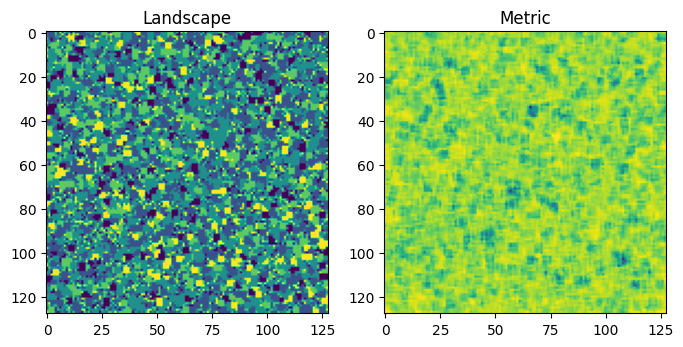

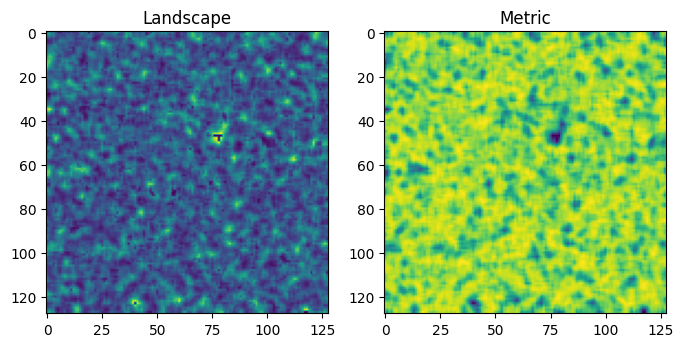

In [62]:
if TEST_MODEL:
    visualize(test_dataset[4]['landscape'].squeeze(), test_dataset[4]['metric'][0].squeeze())
    visualize(test_dataset[4]['metric'][1].squeeze(), test_dataset[4]['metric'][2].squeeze())

In [ ]:
if TEST_MODEL:
    type(predicted_metric)
    len(predicted_metric)

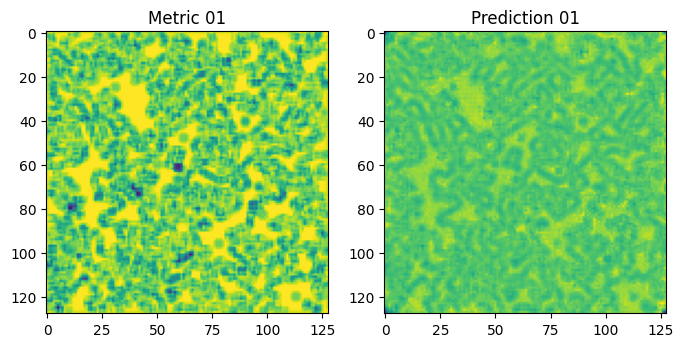

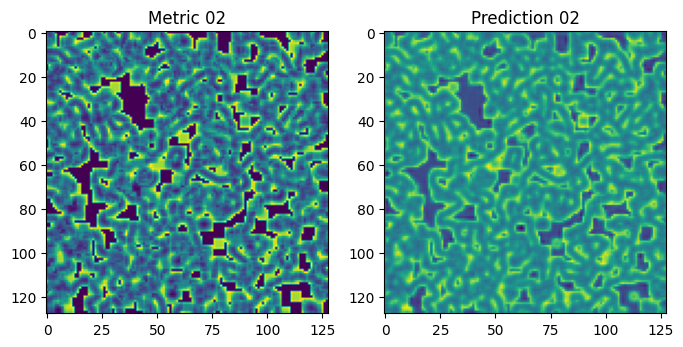

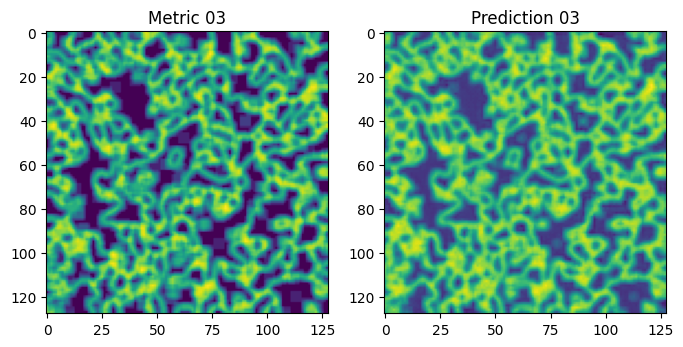

In [65]:
if TEST_MODEL:
    #visualize(predicted_metric[2],predicted_metric[2])
    visualize(test_dataset[5]['metric'][0].squeeze(), predicted_metric[5][0].squeeze(), left_title= "Metric 01", right_title = "Prediction 01")
    visualize(test_dataset[5]['metric'][1].squeeze(), predicted_metric[5][1].squeeze(), left_title= "Metric 02", right_title = "Prediction 02")
    visualize(test_dataset[5]['metric'][2].squeeze(), predicted_metric[5][2].squeeze(), left_title= "Metric 03", right_title = "Prediction 03")

In [ ]:
if TEST_MODEL:
    print(set(test_dataset[4]['metric'].squeeze()[1]))

In [ ]:
if TEST_MODEL:
    print(set(predicted_metric[4].squeeze()[1]))

In [ ]:
if TEST_MODEL:
    difference_loss = test_dataset[5]['metric']-predicted_metric[5]
    #difference_loss = abs(test_dataset[5]['metric']-predicted_metric[5])
    #(test_dataset[5]['metric']-predicted_metric[5]).squeeze()
    
    visualize(test_dataset[5]['metric'].squeeze(),difference_loss.squeeze(), left_title= "Metric", right_title = "Loss")
    #visualize(test_dataset[4]['metric'].squeeze(),predicted_metric[4].squeeze(), left_title= "Metric", right_title = "Prediction")

In [ ]:
if TEST_MODEL:
    print(np.count_nonzero(difference_loss))
    #128*128 == 16384
    print(set(difference_loss.squeeze()))

### q) Submit to Kaggle - `five fold`

In [ ]:
'''
def inference_image(model, images, device='cuda'):
    images = images.to(device)
    predicted = model(images)
    masks = torch.sigmoid(predicted)
    masks = masks.squeeze(1).cpu().detach().numpy()
    return masks
'''

In [ ]:
'''
def inference_model(model, loader, device, use_flip=False):
    mask_dict = {}
    for data in tqdm(loader):
        image_ids = data['image_id']
        images    = data['image']
        masks = inference_image(model, images, device)
        for name, mask in zip(image_ids, masks):
            mask_dict[name] = mask.astype(np.float32)
    return mask_dict
    '''

In [ ]:
'''
# Path to pretrained models from https://www.kaggle.com/aroraaman/siimacr-pretrained/
checkpoints_list=['../data/bst_model512_fold1_0.9492.bin', 
                  '../data/bst_model512_fold2_0.9565.bin', 
                  '../data/bst_model512_fold3_0.9608.bin', 
                  '../data/bst_model512_fold4_0.9604.bin']
'''

In [ ]:
'''
mask_dict = defaultdict(int)
for pred_idx, checkpoint_path in enumerate(checkpoints_list):
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()
    current_mask_dict = inference_model(model, test_dataloader, device='cuda')
    for name, mask in current_mask_dict.items():
        mask_dict[name] = (mask_dict[name] * pred_idx + mask) / (pred_idx + 1)
        
'''

In [ ]:
#len(mask_dict)

def creat_search_run():
    """
    Function to save the Grid Search results.
    """
    num_search_dirs = len(glob.glob('../outputs/search_*'))
    search_dirs = f"../outputs/search_{num_search_dirs+1}"
    os.makedirs(search_dirs)
    return search_dirs
def save_best_hyperparam(text, path):
    """
    Function to save best hyperparameters in a `.yml` file.
    :param text: The hyperparameters dictionary.
    :param path: Path to save the hyperparmeters.
    """
    with open(path, 'a') as f:
        f.write(f"{str(text)}\n")Model Paths for ensemble
- `../data/bst_model512_0.8193.bin` (fold-0)
- `../data/bst_model512_fold1_0.9492.bin` (fold-1)
- `../data/bst_model512_fold2_0.9565.bin`(fold-2)
- `../data/bst_model512_fold3_0.9608.bin` (fold-3)

### r) Gridsearch

In [ ]:
if GRID_SEARCH or GRID_SEARCH_OPTIM:
    '''
    import glob as glob
    def creat_search_run():
        """
        Function to save the Grid Search results.
        """
        num_search_dirs = len(glob.glob(' ../notebooks/data/grid_search/search_*'))       
        search_dirs = f" ../notebooks/data/grid_search/search_{num_search_dirs+1}"
        os.makedirs(search_dirs)
        return search_dirs
    '''
    def save_best_hyperparam(text, path):
        """
        Function to save best hyperparameters in a `.yml` file.
        :param text: The hyperparameters dictionary.
        :param path: Path to save the hyperparmeters.
        """
        #if os.stat(path).st_size == 0:
         #   with open(path, 'a') as f:          
          #      f.write(f"{str(text.keys())[11:-2]}\n")

        with open(path, 'a') as f:  
            if os.stat(path).st_size == 0:
                f.write(f"{str(text.keys())[11:-2]}\n")

            #f.write(f"{str(text)}\n")
            f.write(f"{str(text.values())[13:-2]}\n")

In [ ]:
if GRID_SEARCH:
    from sklearn.model_selection import ParameterGrid

    # define the grid search parameters
    param_grid = {
        #val batch size doesn't really matter?       
        'TRAIN_BATCH_SIZE': [8, 16],# 16],# 24]#, 32]#10, 20, 40, 60, 80, 100],  
        'LEARNING_RATE': [2e-4],# 2e-3, 0.01],#, 0.01]#,       
        'EPOCHS': [10],#, 50, 100],
        'LOSS_FN'   : ['MSE'] #['MAE', 'MAE']#, 'RMSE', 'MAE']
        #'EVAL_FN' : ['R2']#['MSE', 
        #'NUM_WORKERS'      = [4, 8, 12]
    }
    
#list(ParameterGrid(param_grid))


In [ ]:
2e-5 * 1000

In [ ]:
if GRID_SEARCH:  
    
    es = EarlyStopping(patience=3, mode='max')
    
    for param_dict in ParameterGrid(param_grid):
        TRAIN_BATCH_SIZE = param_dict['TRAIN_BATCH_SIZE']
        LEARNING_RATE = param_dict['LEARNING_RATE']
        EPOCHS = param_dict['EPOCHS']
        LOSS_FN = param_dict['LOSS_FN']
        #EVAL_FN = param_dict['EVAL_FN']

            # dataloaders # grid search with smaller learning size, i.e. 10k as in test data?
        train_dataloader = DataLoader(test_dataset, TRAIN_BATCH_SIZE, 
                                      shuffle=True if not USE_SAMPLER else False, 
                                      num_workers=NUM_WORKERS, 
                                      sampler=SAMPLER if USE_SAMPLER else None)

        optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)

        if LOSS_FN == 'MAE':
            criterion = nn.L1Loss()

        # MSE & RMSE
        elif LOSS_FN == 'MSE' or LOSS_FN == 'RMSE':
            criterion = nn.MSELoss()
        
        es.counter = 0

        for epoch in range(EPOCHS):
            loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
            eval_score = evaluate(val_dataloader, model, criterion=eval_metric)      
            scheduler.step()
            param_dict = {'EPOCH': epoch, 'TRAIN LOSS': loss, 'VAL SCORE': float(eval_score), 'LOSS FN': LOSS_FN, 'BATCH SZ': TRAIN_BATCH_SIZE }
            param_string = str(param_dict)
            print(param_string)
            es(eval_score, model, model_path=f"../notebooks/data/grid_search/bst_model{IMG_SIZE}_lr:_{LEARNING_RATE}_btch:_{TRAIN_BATCH_SIZE},lfn:_{LOSS_FN}_fold{FOLD_ID}_{np.round(eval_score,4)}.bin")
            #save_best_hyperparam(f"EPOCH: {epoch}, TRAIN LOSS: {loss}, VAL SCORE: {eval_score}, LOSS FN: {LOSS_FN}, BATCH SZ: {TRAIN_BATCH_SIZE}, LR: {LEARNING_RATE} ", f"../notebooks/data/grid_search/best_param.yml")
            #save_best_hyperparam(param_dict, f"../notebooks/data/grid_search/best_param.yml")
            save_best_hyperparam(param_dict, f"../notebooks/data/grid_search/best_param.csv")

            if es.early_stop:
                print('\n\n -------------- EARLY STOPPING -------------- \n\n')
                #es.counter = 0
                break

In [ ]:
if GRID_SEARCH_OPTIM:  
    
    from torch import optim
    es = EarlyStopping(patience=3, mode='max')

    # define the grid search parameters
    optim_grid = [optim.SGD, optim.RMSprop, optim.Adagrad, optim.Adadelta,
                      optim.Adam, optim.Adamax, optim.NAdam]
    
    
    for o in optim_grid:
        print(o)
        optimizer = o(model.parameters(), lr= LEARNING_RATE)

        # dataloaders # grid search with smaller learning size, i.e. 10k as in test data?
        train_dataloader = DataLoader(test_dataset, TRAIN_BATCH_SIZE, 
                                      shuffle=True if not USE_SAMPLER else False, 
                                      num_workers=NUM_WORKERS, 
                                      sampler=SAMPLER if USE_SAMPLER else None)

        #optimizer = torch.optim.Adam(model.parameters(), lr= LEARNING_RATE)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(
            optimizer, milestones=[3,5,6,7,8,9,10,11,13,15], gamma=0.75)
        
        es = EarlyStopping(patience=3, mode='max')

        #es.counter = 0
          
        for epoch in range(EPOCHS):
            loss = train_one_epoch(train_dataloader, model, optimizer, criterion)
            eval_score = evaluate(val_dataloader, model, criterion=eval_metric)      
            scheduler.step()
            param_dict = {'OPTIMIZER': o, 'EPOCH': epoch, 'TRAIN LOSS': loss, 'VAL SCORE': float(eval_score), 'LOSS FN': LOSS_FN, 'BATCH SZ': TRAIN_BATCH_SIZE }
            param_string = str(param_dict)
            print(param_string)
            es(eval_score, model, model_path=f"../notebooks/data/grid_search_optim/bst_model{IMG_SIZE}_lr:_{LEARNING_RATE}_btch:_{TRAIN_BATCH_SIZE},lfn:_{LOSS_FN}_fold{FOLD_ID}_{np.round(eval_score,4)}.bin")
            save_best_hyperparam(param_dict, f"../notebooks/data/grid_search_optim/best_optim.csv")

            if es.early_stop:
                print('\n\n -------------- EARLY STOPPING -------------- \n\n')
                break